In [3]:
!pip install pandas matplotlib scipy

  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached pillow-11.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 10.1 MB/s eta 0:00:00a 0:00:01
Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (40.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 13.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 12.7 MB/s eta 0:00:0000:0100:01
Using cached pillow-11.0.0-cp312-cp312-manylin

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants
GRAVITY = 9.81  # Acceleration due to gravity in m/s^2

filename = 'data-export-2024-12-09-13-35-33.csv'

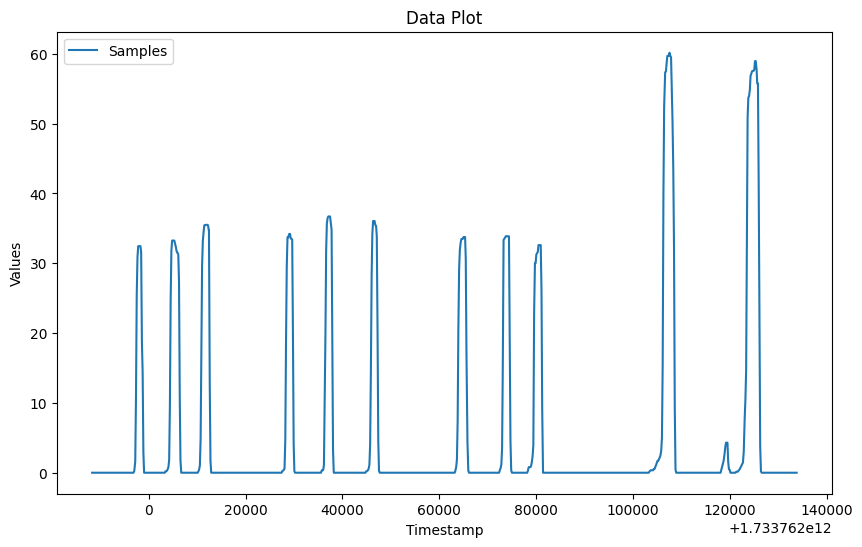

In [5]:

# Read the CSV file
data = pd.read_csv(filename, header=None)

# Assign column names for better readability
data.columns = ['timestamp', 'sample number', 'battRaw', 'samples', 'masses']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['timestamp'], data['samples'], label='Samples')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Data Plot')
plt.legend()

# Show the plot
plt.show()

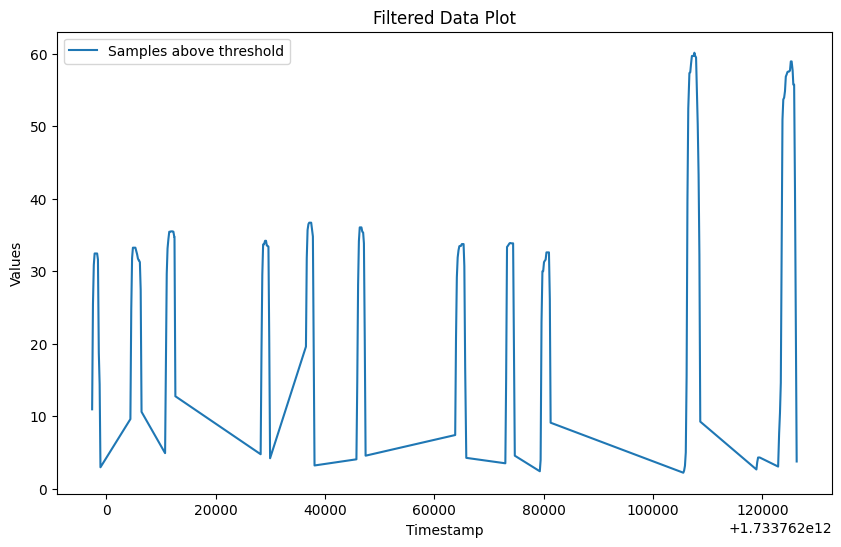

The mean of the values above the threshold is: 30.00 kg | 294.28 N
The calculated Critical Force % relative to body weight value is: 50.00%


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

body_weight = 60  # in kg

# Read the CSV file
data = pd.read_csv(filename, header=None)

# Assign column names for better readability
data.columns = ['timestamp', 'sample number', 'battRaw', 'samples', 'masses']

# Define the threshold
threshold = 2

# Filter the data to include only values above the threshold
filtered_data = data[data['samples'] > threshold]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['timestamp'], filtered_data['samples'], label='Samples above threshold')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Filtered Data Plot')
plt.legend()

# Show the plot
plt.show()

# Calculate the mean of the filtered values
mean_value = filtered_data['samples'].mean()
print(f'The mean of the values above the threshold is: {mean_value:.2f} kg | {mean_value * GRAVITY:.2f} N')
print(f'The calculated Critical Force % relative to body weight value is: {(mean_value / body_weight) * 100:.2f}%')

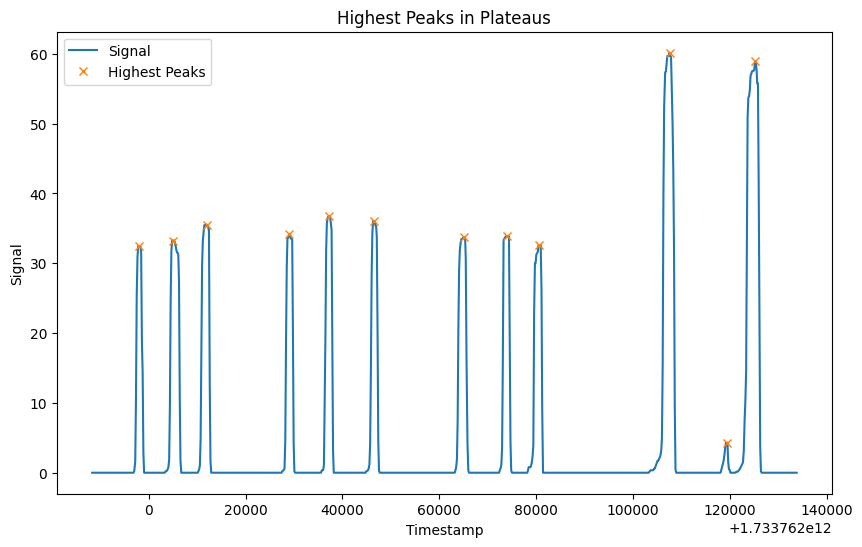

        Timestamp  Signal Value
0   1733761997985         32.45
1   1733762004991         33.25
2   1733762011941         35.50
3   1733762029024         34.20
4   1733762037253         36.70
5   1733762046494         36.05
6   1733762065179         33.75
7   1733762073903         33.90
8   1733762080663         32.60
9   1733762107578         60.15
10  1733762119387          4.30
11  1733762125219         58.95


In [7]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Read the CSV file
data = pd.read_csv(filename, header=None)

# Assign column names for better readability
data.columns = ['timestamp', 'sample number', 'battRaw', 'samples', 'masses']

# Find the peaks in the 'samples' column
peaks, _ = find_peaks(data['samples'])

# Extract the relevant columns: timestamp and signal
timestamps = data.iloc[:, 0]
signal = data.iloc[:, 3]

# Define a threshold for grouping peaks into plateaus (e.g., based on timestamp differences)
threshold = 5000  # Adjust this value depending on the spacing of your data

# Group peaks into plateaus
plateaus = []
current_plateau = [peaks[0]]

for i in range(1, len(peaks)):
    if timestamps.iloc[peaks[i]] - timestamps.iloc[peaks[i - 1]] < threshold:
        current_plateau.append(peaks[i])
    else:
        plateaus.append(current_plateau)
        current_plateau = [peaks[i]]
plateaus.append(current_plateau)

# Find the highest peak in each plateau
highest_peaks = [max(plateau, key=lambda idx: signal.iloc[idx]) for plateau in plateaus]

# Plot the signal with the highest peaks marked
plt.figure(figsize=(10, 6))
plt.plot(timestamps, signal, label="Signal")
plt.plot(timestamps.iloc[highest_peaks], signal.iloc[highest_peaks], "x", label="Highest Peaks")
plt.title("Highest Peaks in Plateaus")
plt.xlabel("Timestamp")
plt.ylabel("Signal")
plt.legend()
plt.show()

# Output the highest peaks' timestamps and values
highest_peaks_output = pd.DataFrame({
    "Timestamp": timestamps.iloc[highest_peaks].values,
    "Signal Value": signal.iloc[highest_peaks].values
})
print(highest_peaks_output)


In [8]:
# Initialize a list to store the RFD results
rfd_results = []

for plateau in plateaus:
    # Get the indices of the current plateau
    highest_peak_idx = max(plateau, key=lambda idx: signal.iloc[idx])  # Index of the highest peak

    # Find the plateau start time (last point near 0 before the plateau begins)
    start_idx = plateau[0]
    for idx in range(start_idx - 1, -1, -1):
        if signal.iloc[idx] <= 0.1:  # Threshold for signal baseline (adjustable)
            start_idx = idx
            break

    # Calculate the time taken to reach the highest peak (in seconds)
    start_time = timestamps.iloc[start_idx]
    peak_time = timestamps.iloc[highest_peak_idx]
    time_to_peak = (peak_time - start_time) / 1000  # Convert milliseconds to seconds

    # Calculate the rate of force development (RFD)
    peak_value = signal.iloc[highest_peak_idx]
    rfd = peak_value / time_to_peak if time_to_peak > 0 else None  # Avoid division by zero

    # Store the results
    rfd_results.append({
        "Plateau Start Time": start_time,
        "Peak Time": peak_time,
        "Time to Peak (s)": time_to_peak,
        "Peak Value (kg)": peak_value,
        "Peak Value (N)": peak_value * GRAVITY,
        "RFD (kg/s)": rfd,
        "RFD (N/s)": rfd * GRAVITY if rfd is not None else None
    })

# Convert results to a DataFrame for better visualization
rfd_df = pd.DataFrame(rfd_results)

# Display the results
print(rfd_df)



    Plateau Start Time      Peak Time  Time to Peak (s)  Peak Value (kg)  \
0        1733761996868  1733761997985             1.117            32.45   
1        1733762003319  1733762004991             1.672            33.25   
2        1733762010117  1733762011941             1.824            35.50   
3        1733762027441  1733762029024             1.583            34.20   
4        1733762035580  1733762037253             1.673            36.70   
5        1733762044772  1733762046494             1.722            36.05   
6        1733762063203  1733762065179             1.976            33.75   
7        1733762072374  1733762073903             1.529            33.90   
8        1733762078178  1733762080663             2.485            32.60   
9        1733762103259  1733762107578             4.319            60.15   
10       1733762118113  1733762119387             1.274             4.30   
11       1733762121203  1733762125219             4.016            58.95   

    Peak Va

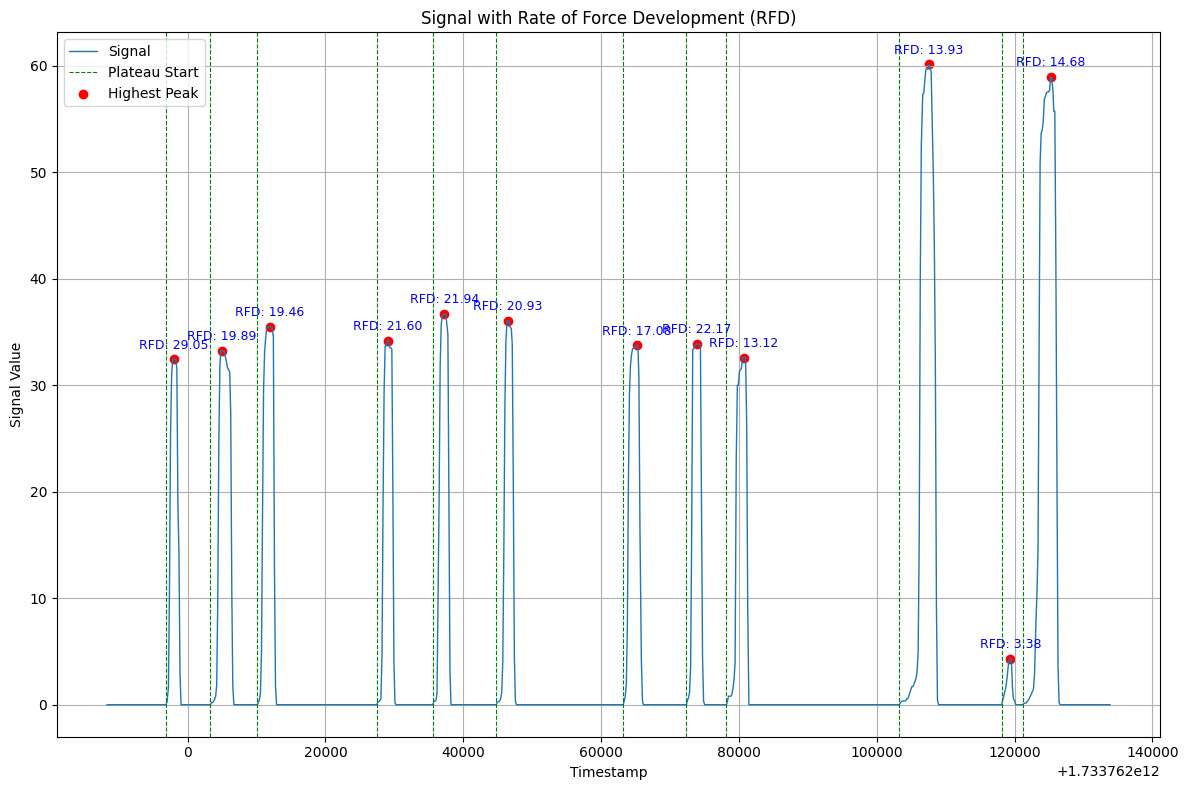

In [13]:
# Plot the signal
plt.figure(figsize=(12, 8))
plt.plot(timestamps, signal, label="Signal", linewidth=1)

# Plot and annotate RFD data
for rfd_entry in rfd_results:
    start_time = rfd_entry["Plateau Start Time"]
    peak_time = rfd_entry["Peak Time"]
    peak_value = rfd_entry["Peak Value (kg)"]
    rfd = rfd_entry["RFD (kg/s)"]

    # Plot plateau start time
    plt.axvline(start_time, color="green", linestyle="--", linewidth=0.8, label="Plateau Start" if "Plateau Start" not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.scatter(peak_time, peak_value, color="red", label="Highest Peak" if "Highest Peak" not in plt.gca().get_legend_handles_labels()[1] else "")

    # Annotate RFD value
    plt.text(
        peak_time, peak_value + 1,  # Position slightly above the peak value
        f"RFD: {rfd:.2f}", fontsize=9, color="blue", ha="center"
    )

# Customize the plot
plt.title("Signal with Rate of Force Development (RFD)")
plt.xlabel("Timestamp")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
